# PLINDER validation/test set

In [1]:
import os

import plinder.core.utils.config

cfg = plinder.core.get_config()

# print(f"local cache directory: {cfg.data.plinder_dir}")
print(f"remote data directory: {cfg.data.plinder_remote}")  # noqa: T201

remote data directory: gs://plinder/2024-06/v2


Use PLINDER package to access the index file.

```python

from plinder.core.scores import query_index

# Get system_id, entry_pdb_id, and split columns of train and val splits
df_index = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "system_num_ligand_chains",
        "system_num_protein_chains",
        "ligand_instance_chain",
    ],
    splits=["val"],
    # splits = ["test"],
)
```

In [2]:
# Save the DataFrame to a CSV file
# splits: val
# df.to_csv("plinder_val_systems.csv", index=False)

# splits: test
# df.to_csv("plinder_test_systems.csv", index=False)

In [3]:
import pandas as pd

# Load index of test systems
df_index = pd.read_csv("./data/plinder_test_systems.csv")

In [4]:
df_index.__len__()

1436

In [5]:
(df_index.system_id + "@" + df_index.ligand_instance_chain).nunique()

1436

# Protonation

* (run this in a script, not in a notebook)
* (check `plinder_dataset_protonate.py`)

```python
import pandas as pd

from tqdm import tqdm
from protonate import plinder_system_protonate

df = pd.read_csv(
    "./data/plinder_test_systems.csv" # modify the file path here
    )

# each_system_id = df.iloc[0]['system_id']  # Example to access system_id
for each_system_id in tqdm(df['system_id'].unique()):

    # Protonate system for each system_id
    plinder_system_protonate(plinder_system_id=each_system_id)
    
```

# HBond validation

## Batch analysis

In [6]:
import warnings

import prolif as plf
from tqdm import tqdm

warnings.filterwarnings("ignore")


dfs = []
fps = []
dfs_i = []
fps_i = []
i = 0

df_index_map = {}

for idx in tqdm(df_index.index):
    # Load explicit fingerprint
    if not os.path.exists(f"./test/explicit/fp_{idx}.pkl"):  # noqa: PTH110
        print(f"Explicit fingerprint for index {idx} not found, skipping.")  # noqa: T201
        continue
    if not os.path.exists(f"./test/implicit/fp_{idx}.pkl"):  # noqa: PTH110
        print(f"Implicit fingerprint for index {idx} not found, skipping.")  # noqa: T201
        continue
    fp = plf.Fingerprint.from_pickle(f"./test/explicit/fp_{idx}.pkl")
    df = fp.to_dataframe().T
    dfs.append(df)
    fps.append(fp)

    # Load implicit fingerprint
    fp = plf.Fingerprint.from_pickle(f"./test/implicit/fp_{idx}.pkl")
    df = fp.to_dataframe().T
    dfs_i.append(df)
    fps_i.append(fp)
    df_index_map[i] = idx
    i += 1

    if idx == 2000:
        break

/home/yuyang/Project_local/GSoC2025_Hbond_PM/.venv/lib/python3.11/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)
  5%|▍         | 66/1436 [00:00<00:08, 167.22it/s]

Explicit fingerprint for index 33 not found, skipping.


 10%|▉         | 139/1436 [00:00<00:06, 187.02it/s]

Explicit fingerprint for index 92 not found, skipping.
Explicit fingerprint for index 93 not found, skipping.
Explicit fingerprint for index 94 not found, skipping.
Explicit fingerprint for index 95 not found, skipping.


 13%|█▎        | 188/1436 [00:01<00:05, 214.51it/s]

Implicit fingerprint for index 156 not found, skipping.


 20%|██        | 288/1436 [00:01<00:04, 235.49it/s]

Implicit fingerprint for index 241 not found, skipping.
Implicit fingerprint for index 261 not found, skipping.


 29%|██▉       | 417/1436 [00:02<00:05, 185.91it/s]

Explicit fingerprint for index 385 not found, skipping.
Explicit fingerprint for index 386 not found, skipping.


 40%|████      | 578/1436 [00:02<00:03, 260.69it/s]

Explicit fingerprint for index 537 not found, skipping.
Explicit fingerprint for index 538 not found, skipping.


 47%|████▋     | 669/1436 [00:03<00:02, 284.18it/s]

Explicit fingerprint for index 619 not found, skipping.
Explicit fingerprint for index 630 not found, skipping.
Explicit fingerprint for index 631 not found, skipping.


 68%|██████▊   | 972/1436 [00:04<00:01, 253.49it/s]

Explicit fingerprint for index 936 not found, skipping.
Explicit fingerprint for index 937 not found, skipping.


 74%|███████▎  | 1059/1436 [00:04<00:01, 269.08it/s]

Explicit fingerprint for index 1025 not found, skipping.
Explicit fingerprint for index 1026 not found, skipping.


 85%|████████▌ | 1222/1436 [00:05<00:01, 201.69it/s]

Explicit fingerprint for index 1174 not found, skipping.
Explicit fingerprint for index 1175 not found, skipping.


 91%|█████████ | 1309/1436 [00:06<00:00, 252.34it/s]

Explicit fingerprint for index 1252 not found, skipping.
Implicit fingerprint for index 1309 not found, skipping.
Implicit fingerprint for index 1311 not found, skipping.


100%|██████████| 1436/1436 [00:06<00:00, 222.27it/s]


In [7]:
len(dfs)

1412

Troubleshooting

In [8]:
df_index.iloc[1311]

system_id                    5ohe__2__1.C_1.D__1.N_1.O
entry_pdb_id                                      5ohe
system_num_ligand_chains                             2
system_num_protein_chains                            2
ligand_instance_chain                              1.O
split                                             test
Name: 1311, dtype: object

In [9]:
import numpy as np
from utils.metrics import (
    get_interactions,
    positive_predictive_value,
    sensitivity,
    tanimoto_coefficient,
)
from utils.postprocess import get_metadata_from_implicit_hbond_using_set

# idx = 5
all_aaa_dev_list = []
all_daa_dev_list = []
all_dpa_list = []
all_apa_list = []
all_vhp_list = []

all_fp_aaa_dev_list = []
all_fp_daa_dev_list = []
all_fp_dpa_list = []
all_fp_apa_list = []
all_fp_avp_list = []
all_fp_vhp_list = []


tm_coefs = []
ppvs = []
sensitivities = []

for idx in range(len(dfs_i)):
    # Get the explicit interaction's implicit metadata
    explicit_set = get_interactions(dfs[idx])

    aaa_dev_list, daa_dev_list, dpa_list, apa_list, vina_hbond_potential_list = (
        get_metadata_from_implicit_hbond_using_set(explicit_set, fps_i[idx])
    )
    all_aaa_dev_list.extend(aaa_dev_list)
    all_daa_dev_list.extend(daa_dev_list)
    all_dpa_list.extend(dpa_list)
    all_apa_list.extend(apa_list)
    all_vhp_list.extend(vina_hbond_potential_list)

    # Get the false positive interaction's implicit metadata
    implicit_set = get_interactions(dfs_i[idx])
    false_positive_set = implicit_set - explicit_set
    false_negative_set = explicit_set - implicit_set
    fp_aaa_dev_list, fp_daa_dev_list, fp_dpa_list, fp_apa_list, fp_vhp_list = (
        get_metadata_from_implicit_hbond_using_set(false_positive_set, fps_i[idx])
    )
    all_fp_aaa_dev_list.extend(fp_aaa_dev_list)
    all_fp_daa_dev_list.extend(fp_daa_dev_list)
    all_fp_dpa_list.extend(fp_dpa_list)
    all_fp_apa_list.extend(fp_apa_list)
    all_fp_vhp_list.extend(fp_vhp_list)

    # Calculate Tanimoto coefficient
    tm_coef = tanimoto_coefficient(explicit_set, implicit_set)
    tm_coefs.append(tm_coef)
    ppv = positive_predictive_value(explicit_set, implicit_set)
    ppvs.append(ppv)
    sens = sensitivity(explicit_set, implicit_set)
    sensitivities.append(sens)

    # To find the case
    if any(np.array(aaa_dev_list) > 80) and idx not in {
        375,
        # This example is due to the overlapping of the receptor and ligand,
        # nothing I can do.
        772,
        # This example is a perfect match. The explicit H shows
        # the large atom angle is reasonable.
        1194,  # This example is due to the overlapping of the receptor and ligand,
        # nothing I can do.
    }:
        # print(f"High deviation found in {idx}.")
        # print("Tanimoto:", tm_coef)
        # break
        pass

    if len(false_negative_set) > 0 and idx not in {
        2,  # Donor atom angle 26°
        3,  # Donor atom angle 28°
        7,  # Donor atom angle 27°
        18,  # Donor plane angle 33°
    }:
        # print(f"False negative found in {idx}.")
        # print(false_negative_set)
        # print("Tanimoto:", tm_coef)
        # break
        pass

    if any(np.array(vina_hbond_potential_list) < 0.2):
        # print(f"Low Vina H-bond potential found in {idx}.")
        # break
        pass
# print("Tanimoto coefficients:", np.mean(tm_coefs))
# print("Positive Predictive Values:", np.mean(ppvs))
# print("Sensitivities:", np.mean(sensitivities))

In [10]:
idx = 6  # Example index to test

print(df_index.iloc[df_index_map[idx]])  # noqa: T201

plinder_system_id = df_index.iloc[df_index_map[idx]]["system_id"]
ligand_instance_chain = df_index.iloc[df_index_map[idx]]["ligand_instance_chain"]

system_id                    3p5p__1__1.A__1.B_1.C_1.E
entry_pdb_id                                      3p5p
system_num_ligand_chains                             3
system_num_protein_chains                            1
ligand_instance_chain                              1.E
split                                             test
Name: 6, dtype: object


In [11]:
dfs[idx], dfs_i[idx]

(Frame                        0
 ligand protein  interaction   
 UNL1   ARG648.A HBAcceptor   1
        ASN651.A HBAcceptor   2
        GLU659.A HBDonor      1
        HOH2._   HBAcceptor   1,
 Frame                               0
 ligand protein  interaction          
 UNL1   ARG648.A ImplicitHBAcceptor  1
        ASN651.A ImplicitHBDonor     1
                 ImplicitHBAcceptor  2
        THR655.A ImplicitHBAcceptor  1
        GLU659.A ImplicitHBDonor     1
        HOH1._   ImplicitHBDonor     1
                 ImplicitHBAcceptor  2
        HOH2._   ImplicitHBDonor     1
                 ImplicitHBAcceptor  2
        HOH3._   ImplicitHBAcceptor  1
        HOH4._   ImplicitHBDonor     2
                 ImplicitHBAcceptor  2
        HOH5._   ImplicitHBAcceptor  1)

In [12]:
from prolif import Molecule
from prolif.io.protein_helper import ProteinHelper
from rdkit import Chem

protein_helper = ProteinHelper(
    templates={
        "ACE": {"SMILES": "CC=O"},
    }
)

test_case_dir = f"{cfg.data.plinder_dir}/protonated_systems/{plinder_system_id}"
ligand_sdf = f"{test_case_dir}/{ligand_instance_chain}_protonated.sdf"

protein_mol = protein_helper.standardize_protein(
    Molecule.from_rdkit(
        Chem.MolFromPDBFile(
            f"{test_case_dir}/receptor_protonated.pdb",
            sanitize=False,
            removeHs=False,
            proximityBonding=True,
        )
    )
)
ligand = plf.sdf_supplier(ligand_sdf)[0]

ligand_i = Molecule.from_rdkit(Chem.RemoveAllHs(ligand))
protein_mol_i = protein_helper.standardize_protein(
    Molecule.from_rdkit(Chem.RemoveAllHs(protein_mol, sanitize=False))
)

In [13]:
from prolif.residue import ResidueId

fps_i[idx].ifp[0][ResidueId("UNL", 1, None), ResidueId("ASN", 651, "A")]

{'ImplicitHBDonor': ({'indices': {'ligand': (11,), 'protein': (6,)},
   'parent_indices': {'ligand': (11,), 'protein': (5230,)},
   'distance': 3.3183827028177104,
   'ideal_acceptor_angle': 120.0,
   'acceptor_atom_angles': [97.20077234607521],
   'acceptor_atom_angle_deviation': 22.79922765392479,
   'acceptor_plane_angle': 12.48641498108908,
   'ideal_donor_angle': 109.5,
   'donor_atom_angles': [123.40010046497734],
   'donor_atom_angle_deviation': 13.900100464977342,
   'vina_hbond_potential': 0.24910838099221164},),
 'ImplicitHBAcceptor': ({'indices': {'ligand': (10,), 'protein': (7,)},
   'parent_indices': {'ligand': (10,), 'protein': (5231,)},
   'distance': 3.197632306101267,
   'ideal_acceptor_angle': 120.0,
   'acceptor_atom_angles': [100.7073965983514],
   'acceptor_atom_angle_deviation': 19.292603401648606,
   'acceptor_plane_angle': 76.0589653748044,
   'ideal_donor_angle': 120.0,
   'donor_atom_angles': [137.51654918693555],
   'donor_atom_angle_deviation': 17.5165491869

In [14]:
# create Complex3D objects (default)
comp3D = fps[idx].plot_3d(ligand, protein_mol, frame=0)
other_comp3D = fps_i[idx].plot_3d(ligand_i, protein_mol_i, frame=0)


# compare the two Complex3D objects
view = comp3D.compare(other_comp3D, display_all=True, remove_hydrogens=False)
view.setStyle(
    {
        "resn": "HOH",
    },
    {"sphere": {"radius": 0.3}},
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
fp_i = plf.Fingerprint(
    interactions=["ImplicitHBDonor", "ImplicitHBAcceptor"],
    parameters={
        "ImplicitHBDonor": {"tolerance_dev_daa": 90, "tolerance_dev_dpa": 90},
        "ImplicitHBAcceptor": {"tolerance_dev_daa": 90, "tolerance_dev_dpa": 90},
    },
)
fp_i.run_from_iterable([ligand_i], protein_mol_i)

  0%|          | 0/1 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 2 interactions: ['ImplicitHBDonor', 'ImplicitHBAcceptor'] at 0x7f997188a050>

In [16]:
fp_i.to_dataframe().T

Frame                                  0
ligand protein  interaction             
UNL1   ARG648.A ImplicitHBAcceptor  True
       ASN651.A ImplicitHBDonor     True
                ImplicitHBAcceptor  True
       THR655.A ImplicitHBDonor     True
                ImplicitHBAcceptor  True
       GLU659.A ImplicitHBDonor     True

In [17]:
# fp_i.ifp[0][("UNL1.", "ASP36.A")]

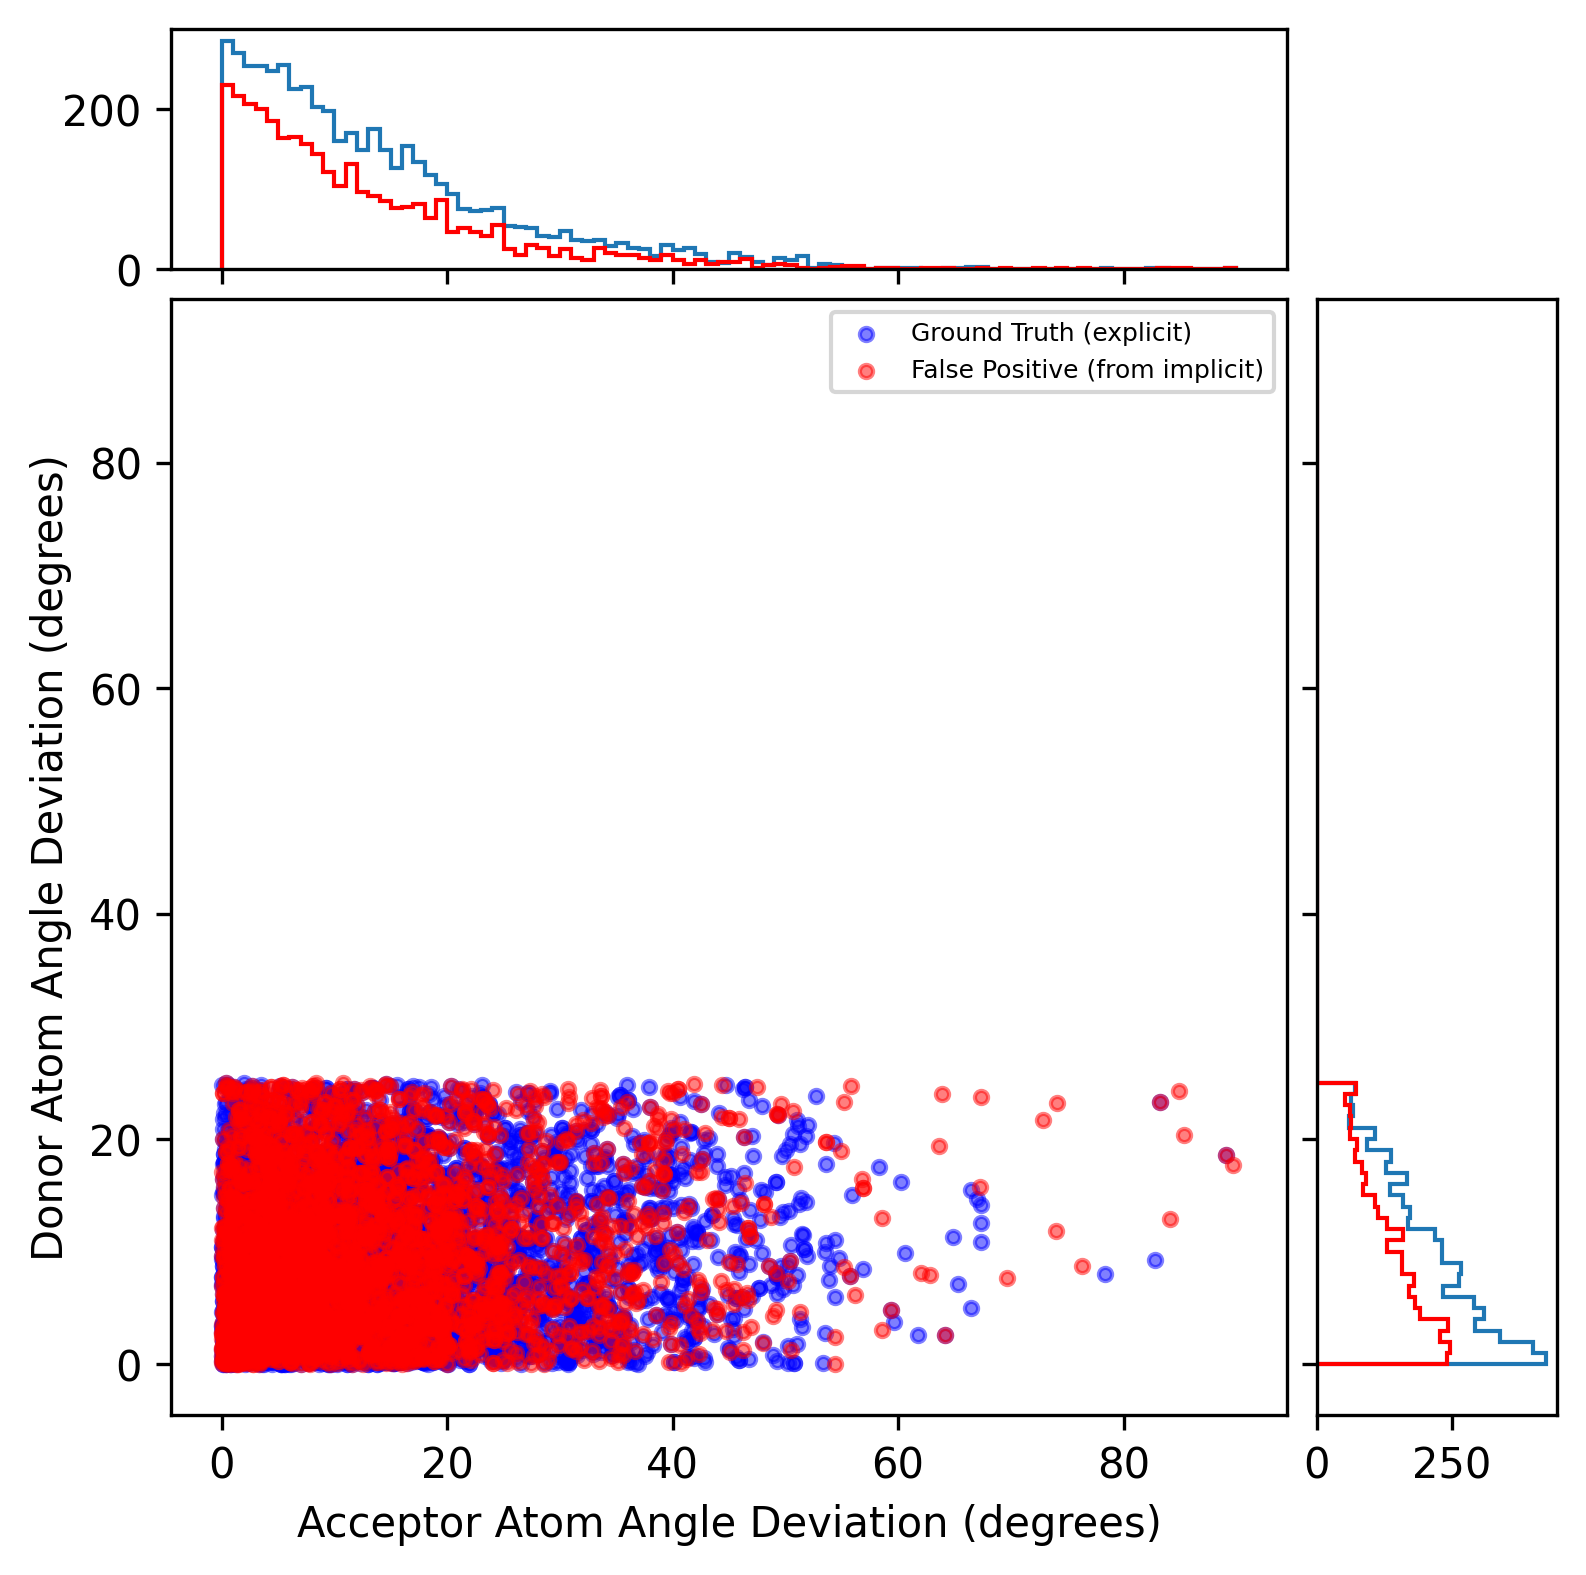

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(dpi=300, figsize=(8, 6))
ax.scatter(all_aaa_dev_list, all_daa_dev_list, s=10, alpha=0.5, c="blue")
ax.scatter(all_fp_aaa_dev_list, all_fp_daa_dev_list, s=10, alpha=0.5, c="red")


# the scatter plot:
# Set aspect of the main Axes.
ax.set_aspect(1.0)

# create new Axes on the right and on the top of the current Axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)

# make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 1
xymax = max(np.max(np.abs(all_aaa_dev_list)), np.max(np.abs(all_daa_dev_list)))
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax_histx.hist(all_aaa_dev_list, bins=bins, histtype="step")
ax_histx.hist(all_fp_aaa_dev_list, bins=bins, histtype="step", color="red")
ax_histy.hist(all_daa_dev_list, bins=bins, histtype="step", orientation="horizontal")
ax_histy.hist(
    all_fp_daa_dev_list,
    bins=bins,
    orientation="horizontal",
    histtype="step",
    color="red",
)

# the xaxis of ax_histx and yaxis of ax_histy are shared with ax,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

# ax_histx.set_yticks([0, 50, 100])
# ax_histy.set_xticks([0, 50, 100])

ax.set_xlabel("Acceptor Atom Angle Deviation (degrees)")
ax.set_ylabel("Donor Atom Angle Deviation (degrees)")
ax.legend(
    ["Ground Truth (explicit)", "False Positive (from implicit)"],
    loc="upper right",
    fontsize=6,
)
fig.show()

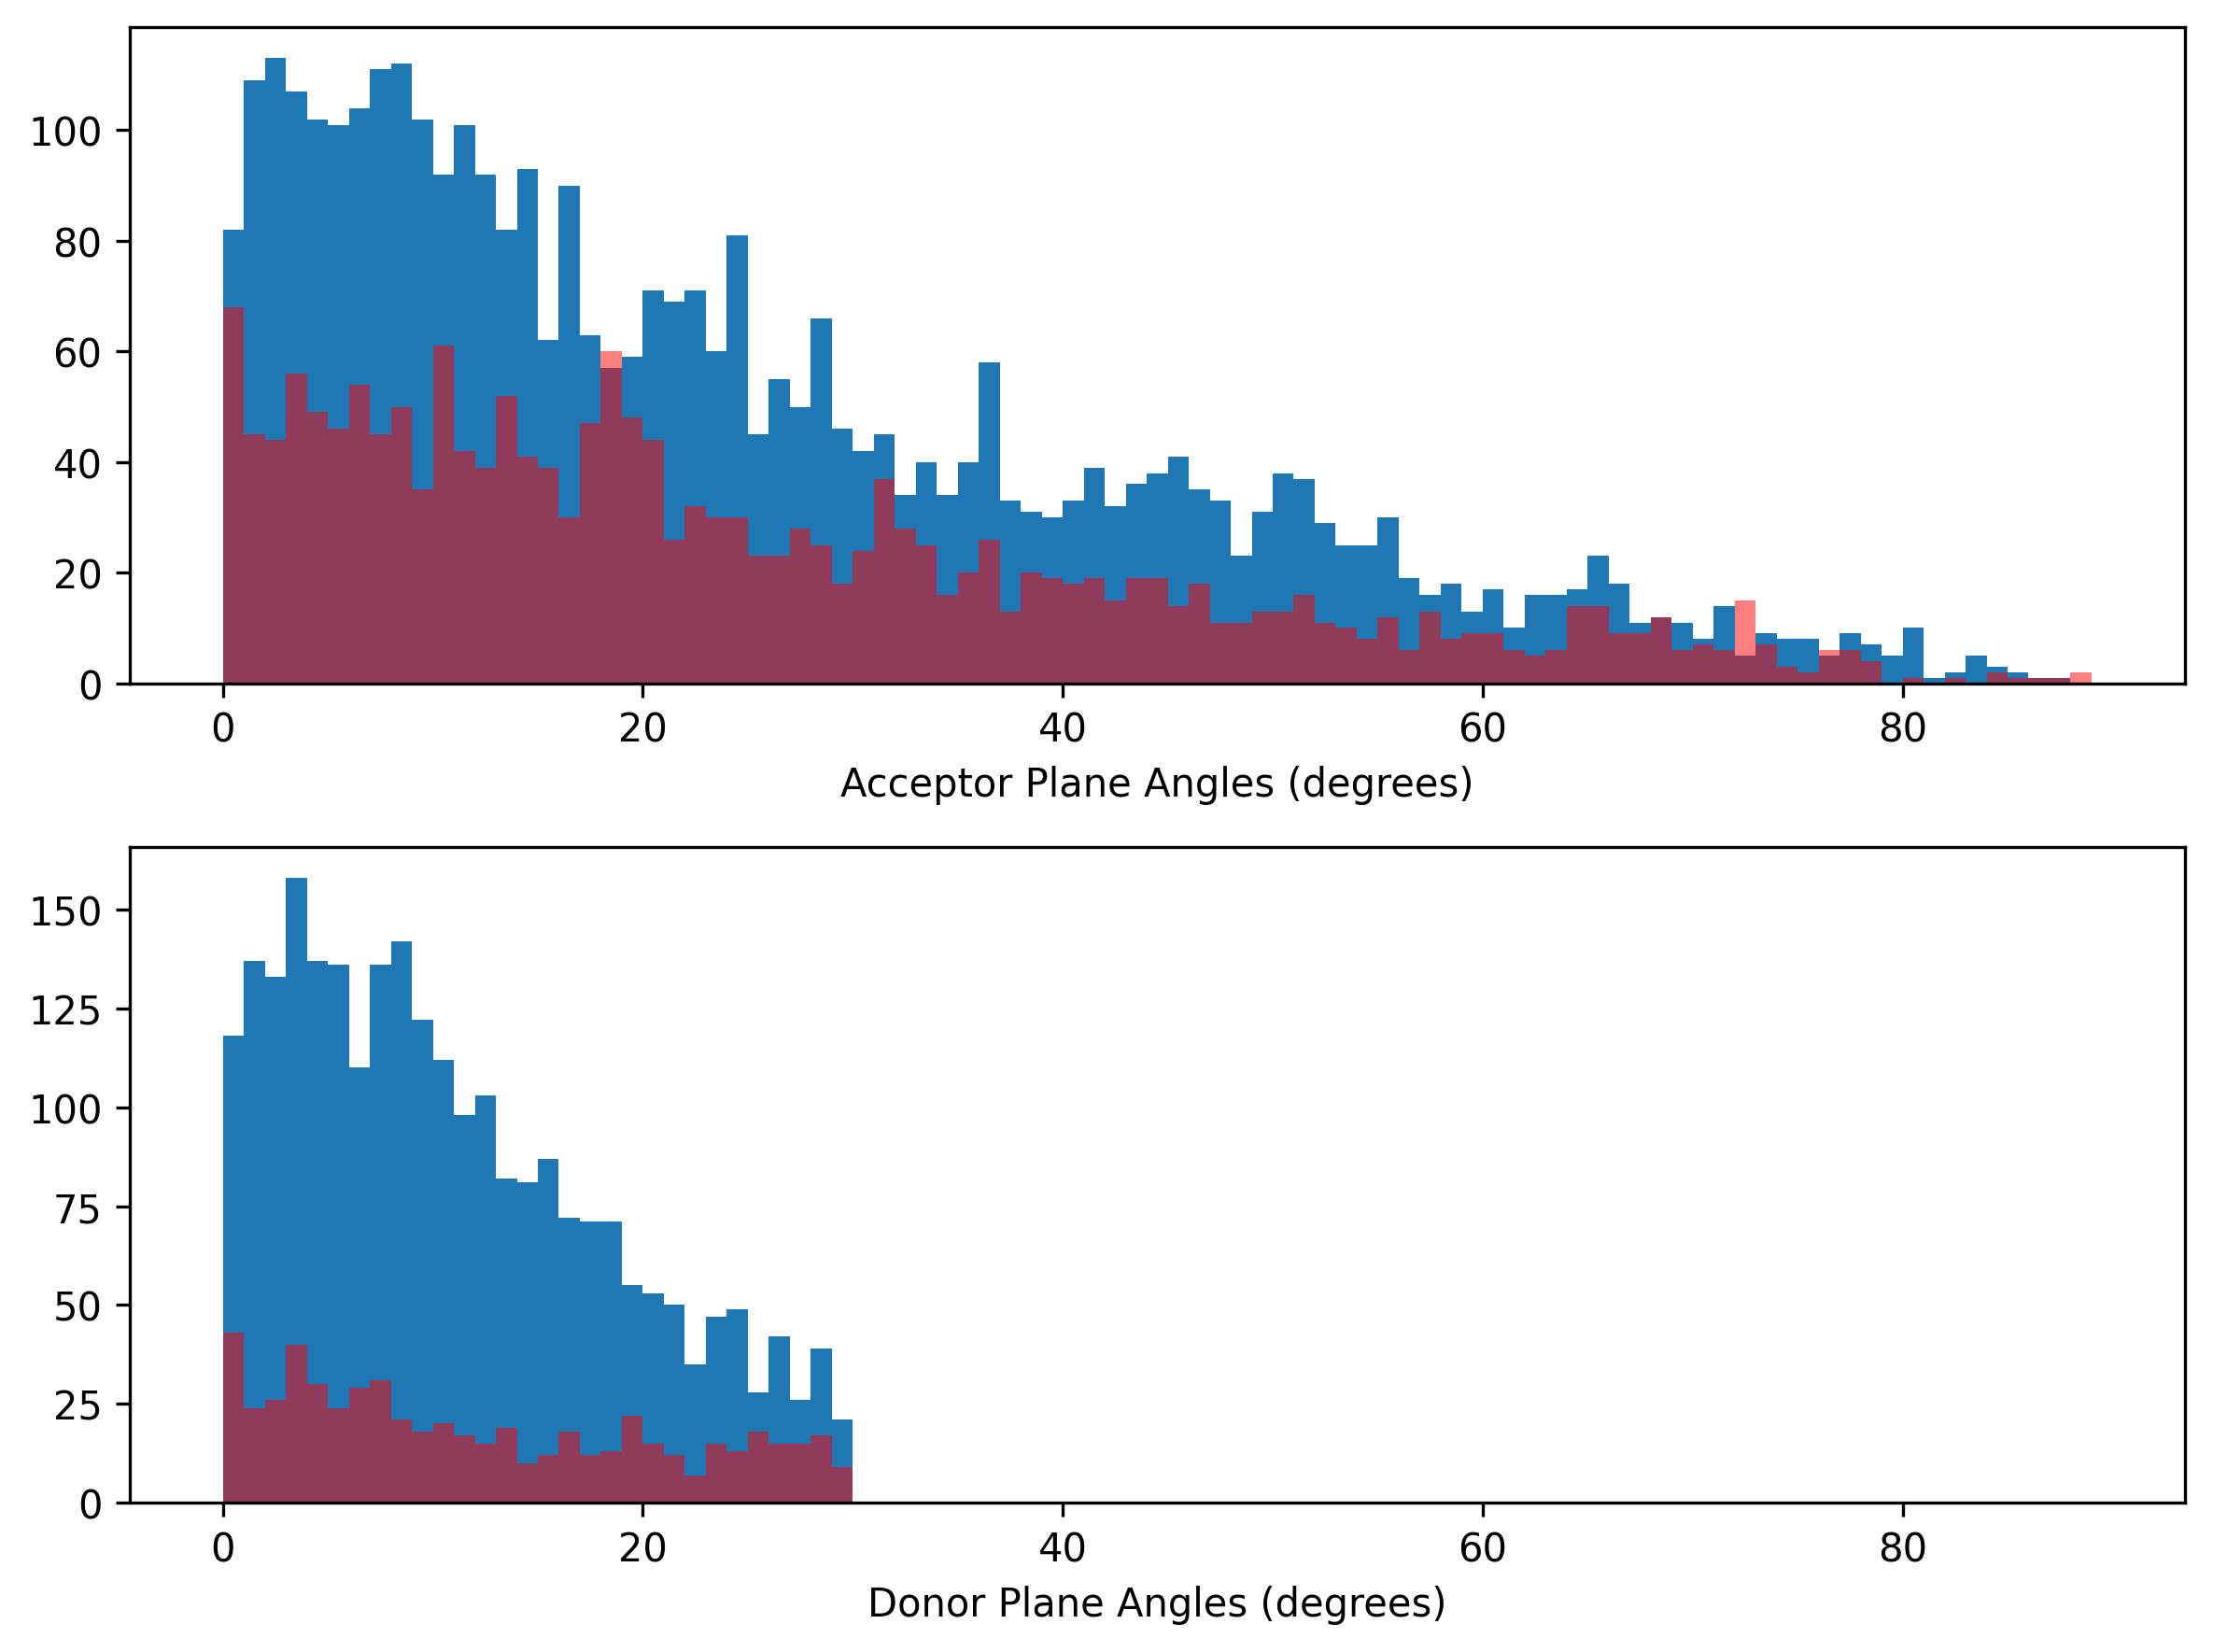

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 1, dpi=300, figsize=(8, 6))

# now determine nice limits by hand:
binwidth = 1
xymax = max(
    np.max(np.abs(all_apa_list)),
    np.max(np.abs(all_dpa_list)),
    np.max(np.abs(all_fp_apa_list)),
    np.max(np.abs(all_fp_dpa_list)),
)
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax[0].hist(all_apa_list, bins=bins)
ax[0].hist(all_fp_apa_list, bins=bins, alpha=0.5, color="red")
ax[1].hist(all_dpa_list, bins=bins)
ax[1].hist(all_fp_dpa_list, bins=bins, alpha=0.5, color="red")

ax[0].set_xlabel("Acceptor Plane Angles (degrees)")
ax[1].set_xlabel("Donor Plane Angles (degrees)")
fig.tight_layout()
fig.show()

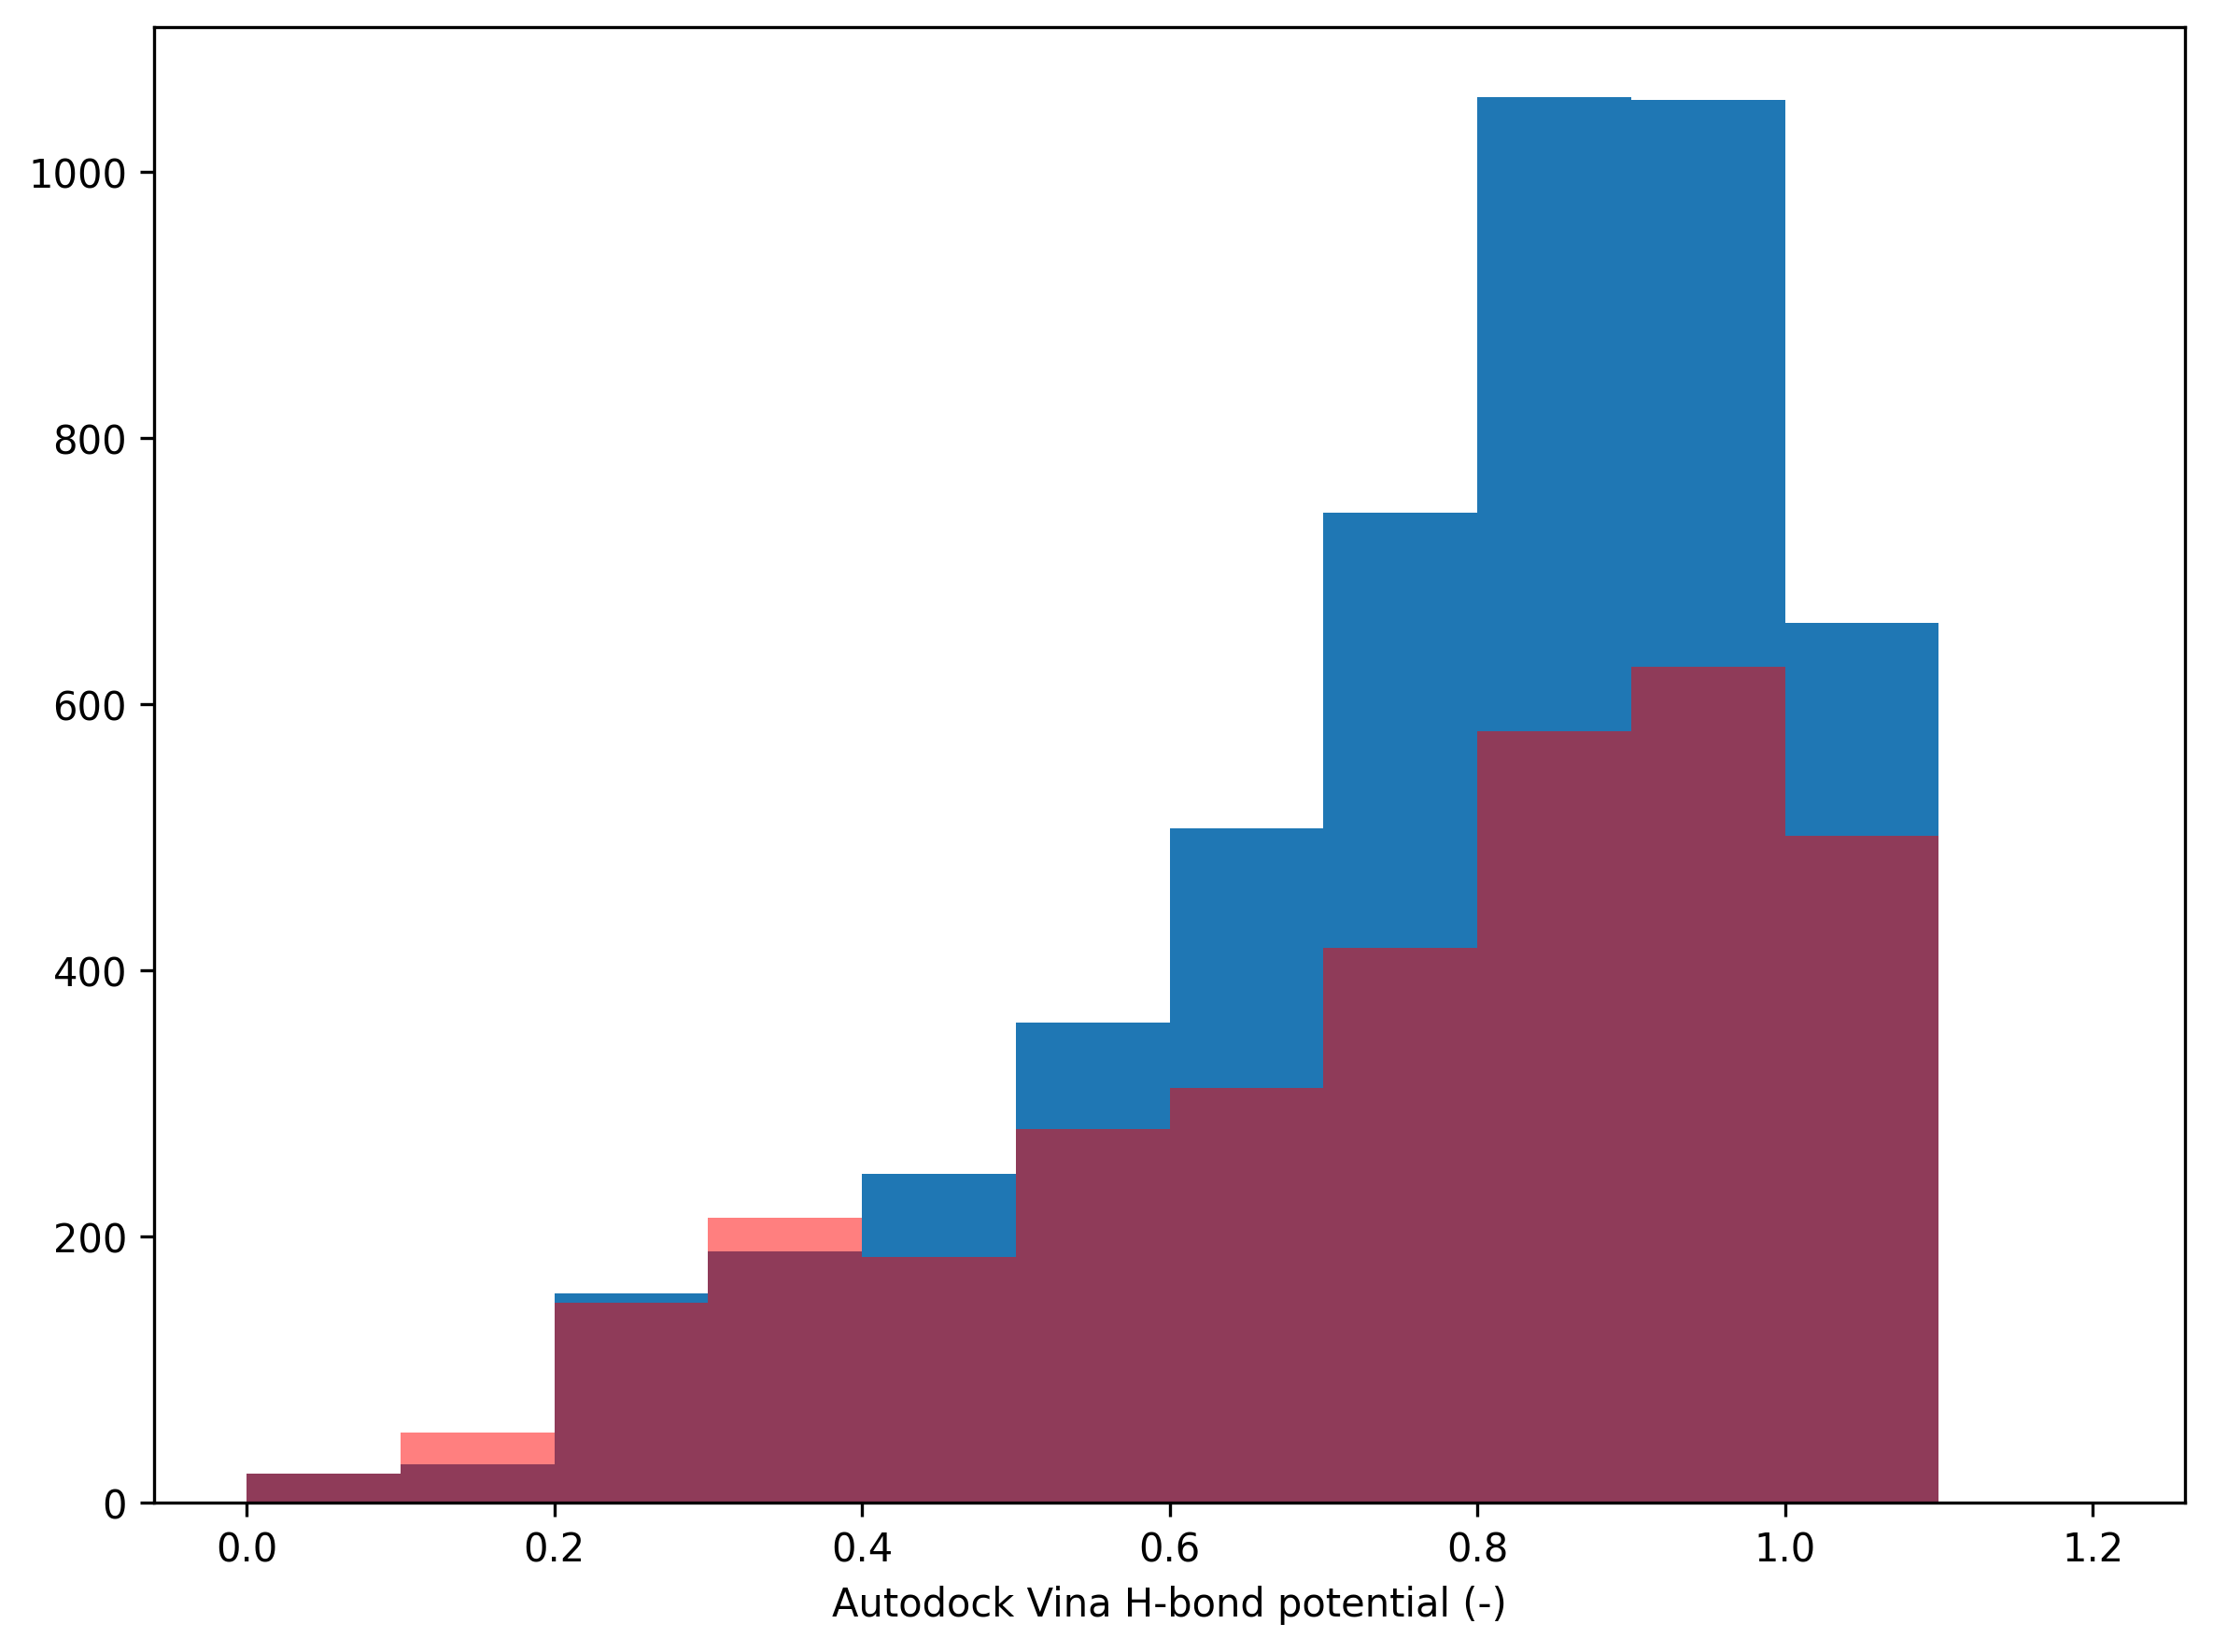

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(8, 6))

# now determine nice limits by hand:
binwidth = 0.1
xymax = max(
    np.max(np.abs(all_vhp_list)),
    np.max(np.abs(all_fp_vhp_list)),
)
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax.hist(all_vhp_list, bins=bins)
ax.hist(all_fp_vhp_list, bins=bins, alpha=0.5, color="red")

ax.set_xlabel("Autodock Vina H-bond potential (-)")
fig.tight_layout()
fig.show()